In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# imports for grid serach
import os
import pickle
from pprint import pprint
from sklearn.datasets import load_files
from sklearn.cross_validation import  ShuffleSplit
from sklearn.grid_search import ParameterGrid
from ipyparallel import Client
from sklearn.externals import joblib
from time import time, sleep


%matplotlib inline

![](http://photos.prnewswire.com/prnvar/20150914/266402LOGO)

## Introduction

The training data is pulled from raw logs. It has three columns that record user activity over time:

    user_id: A hash that uniquely identifies the user.
    activity_date: The date of the activity
    activity_type: The type of activity

6sense would like to predict which users will purchase given the user's activities. 

Using the training data, build a model that predicts which user_id's will make a purchase in the future. Use the model to score the test data from most likely to least likely to purchase.

Please submit the following:
1. Descibe which activity types you believe are most useful in predicting which user will purchase in the future.
2. Provide a file containing the 1000 user_id's most likely to convert.
3. [optional] Any work used to generate the list and/or notes you'd like to include.

## Overview

1. Inspect and tranform the data into a form that we can feed into the machine learing models
2. Cross vaildate model hyperparameters
3. Evaluate our model's performance by analyzing learning curves for 4 metrics
4. Answer the two questions that are asked


### Import, Inspect and Tranform the Data 

In [10]:
# import data
train_path = "/Users/Alexander/DataBeast/TakeHomes/6sense_takehome/training.tsv"
test_path = "/Users/Alexander/DataBeast/TakeHomes/6sense_takehome/test.tsv"
cols = ["user_id", 'activity_date', 'activity_type']
df_train = pd.read_csv(train_path, delimiter='\t', header=None)
df_test = pd.read_csv(test_path, delimiter='\t', header=None)

In [11]:
# label features
cols = ["user_id", 'activity_date', 'activity_type']
df_train.columns = cols
df_test.columns = cols

From the counter print out we can see that the test set does not contain the "Purchase" or "CustomerSupport" features. 
The test set predictions will be validated by 6sense, so the "Purchase" labels are not available. Because the "CustomerSupport" feature is missing from the test set, we will omit it from the training set, since our model will need identical features for both the training and test sets. 

In [12]:
# the test set does not contain the 'CustomerSupport'feature
Counter(df_test.activity_type)

Counter({'EmailClickthrough': 42364,
         'EmailOpen': 550886,
         'FormSubmit': 28765,
         'PageView': 87149,
         'WebVisit': 88595})

In [13]:
Counter(df_train.activity_type)

Counter({'CustomerSupport': 103991,
         'EmailClickthrough': 285568,
         'EmailOpen': 3191732,
         'FormSubmit': 176067,
         'PageView': 382263,
         'Purchase': 395031,
         'WebVisit': 384025})

The dataframe head shows that user ids repeat and all activities are contained under the "activity_type" feautre, including the purchases. This means that we'll need to expand the "activity_type" in such a way so that each activity type becomes its own feature -- this is known and OneHot Enoding. 

In [14]:
df_train.head()

,user_id,activity_date,activity_type
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen


We'll use Sklearn's OneHotEncoder to expand the "activity_type" feature. Then we'll use pandas dataframes two join the expanded features to their corresponding user ids, then collapse all repeats of a user id into a single row. So that each row will represent a unique user. 

In [6]:
def encode_df(df):
    '''K-hot encode each activity type, creating a feature for each activity,
       flatten each user's rows into a single unique user row '''
    master_cols = df.activity_type.unique()
    encoder = OneHotEncoder(categorical_features = "activity_type")
    encoded_df = df.join(pd.get_dummies(df.activity_type))[master_cols]
    oneHot_df = df.join(encoded_df).groupby("user_id").sum()
    
    return oneHot_df

In [7]:
df_train_encode = encode_df(df_train)
df_test_encode = encode_df(df_test)

In [8]:
df_train_encode.head()

,EmailOpen,FormSubmit,Purchase,EmailClickthrough,CustomerSupport,PageView,WebVisit
user_id,,,,,,,
00002acbe042d69,9.0,1.0,0.0,0.0,0.0,0.0,0.0
0000a3a34bd07e6,20.0,0.0,0.0,0.0,0.0,0.0,0.0
0000ecf58c94668,11.0,1.0,6.0,1.0,1.0,0.0,0.0
00012205dd4613b,2.0,0.0,0.0,0.0,0.0,0.0,0.0
000198d39a568cf,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [9]:
df_test_encode.head()

,EmailOpen,EmailClickthrough,FormSubmit,PageView,WebVisit
user_id,,,,,
0000ecf58c94668,5.0,0.0,0.0,0.0,0.0
000132f21724ee2,1.0,1.0,0.0,0.0,0.0
0001b315b991cf0,3.0,0.0,0.0,0.0,0.0
000269150971d08,4.0,0.0,0.0,0.0,0.0
000297ba4fa5026,3.0,0.0,0.0,0.0,0.0


Notice that the user in the 3rd row has made 6 purchases. We are asked to build a model that predicts if a user makes a purchase or not. This is binary classification task that needs to be completed with True/False labels, or zero and one. So we'll replace all purchases greater than 1 with 1. 

In [17]:
purchase_mask = df_train_encode.Purchase > 1.0
df_train_encode.Purchase[purchase_mask] = 1.0

In [18]:
# purchase feature has been given binary labels
df_train_encode.head()

,EmailOpen,FormSubmit,Purchase,EmailClickthrough,CustomerSupport,PageView,WebVisit
user_id,,,,,,,
00002acbe042d69,9.0,1.0,0.0,0.0,0.0,0.0,0.0
0000a3a34bd07e6,20.0,0.0,0.0,0.0,0.0,0.0,0.0
0000ecf58c94668,11.0,1.0,1.0,1.0,1.0,0.0,0.0
00012205dd4613b,2.0,0.0,0.0,0.0,0.0,0.0,0.0
000198d39a568cf,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Modeling

In the modeling phase, we first need to optimize the hyperparameters of the models that we want to fit to the data. This means that we'll need to run a grid serach over the parameter space. We will be using my very own implementation of grid search. After the grid search is done, we'll then want to plot learning curves indicating how well our models are learning as they are trained with an increasing number of training samples. We'll evalulate their performance by tracking the scores of four metrics. Once again, we'll be using my own implementaion of cross validation.

In [12]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, n_splits=3, init_chunk_size = 100, chunk_spacings = 10, average = "binary"):


        self.model = model
        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings
        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []

        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
    
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0] 
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''Returns f1 and accuracy cross validation scores for a given model and data set'''

        
        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.kf.split(self.X[:n]):
                
                self.train_index, self.test_index = train_index, test_index
                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n)
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
            

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);


In [14]:
# Data Engineering functions used to greatly speed up model optimization (i.e. grid search)
def persist_cv_splits(X, y, n_cv_iter=3, name='data', suffix="_cv_%03d.pkl", test_size=0.25, random_state=None):
    """Materialize randomized train test splits of a dataset."""

    cv = ShuffleSplit(X.shape[0], 
                      n_iter=n_cv_iter,
                      test_size=test_size, 
                      random_state=random_state)
    
    cv_split_filenames = []

    for i, (train, test) in enumerate(cv):
        
        cv_fold = (X[train], y[train], X[test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

def compute_evaluation(cv_split_filename, model, params):
    """Function executed by a worker to evaluate a model on a CV split"""
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib
    from sklearn.metrics import f1_score

    X_train, y_train, X_validation, y_validation = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    # accuracy
    #validation_score = model.score(X_validation, y_validation)
    
    # f1_score
    validation_score = f1_score(y_validation, y_pred, average = "macro")
    
    return validation_score

def grid_search(lb_view, model, cv_split_filenames, param_grid):
    """Launch all grid search evaluation tasks."""
    all_tasks = []
    all_parameters = list(ParameterGrid(param_grid))
    
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, model, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

def progress(tasks):
    return np.mean([task.ready() for task_group in tasks
                                 for task in task_group])

def find_bests(all_parameters, all_tasks, n_top=5):
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
        
    
    try: 
        mean_scores = np.array(mean_scores)
        sorted_ind = np.argsort(mean_scores.T[0])[::-1]
        return mean_scores[sorted_ind][:n_top]
    
    except IndexError:
        pass

In [25]:
def undersample(X, y, majority_weight=.5):
    '''
    randomly discards observations from majority class
    so that output X, y have specified percentage of majority observations
    '''
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_majority = X[y==majority_class_label]
    y_majority = y[y==majority_class_label]
    maj_count = len(X_majority)
    min_count = len(X) - maj_count
    scaling_factor = (min_count/float(maj_count))*(majority_weight/(1-majority_weight))
    sample_indices = np.random.choice(list(range(maj_count)), 
                                      size=round(maj_count*scaling_factor),
                                      replace=False)
    X_majority = X_majority[sample_indices]
    y_majority = y_majority[sample_indices]
    X = np.vstack((X_majority, X[y!=majority_class_label]))
    y = np.hstack((y_majority, y[y!=majority_class_label]))
    return X, y

In [26]:
X_cols = ['EmailOpen', 'FormSubmit', 'EmailClickthrough', 'PageView', 'WebVisit']
X = df_train_encode[X_cols].values
Y = df_train_encode.Purchase.values

In [27]:
Counter(Y)

Counter({0.0: 237577, 1.0: 103991})

The counter print out shows that the binary labels are unbalanced. There are about twice as many users that don't make a purchase as there are users that do make a purchase. Unbalanced labels negatively affect the performance of models by biasing them to the dominate class. In order maximize the performance of our models, we'll undersample the majority class. 

In [28]:
# undersample the majority class in order to balance the labels
X, Y = undersample(X, Y, majority_weight=.5)

In [29]:
# we have balanced labels and over 100,000 samples -- so no shortage of data!
Counter(Y)

Counter({0.0: 103991, 1.0: 103991})

In [30]:
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size = 0.20)

In [31]:
# take a subsample of data for cross validation
n_points = 10000
Counter(Y_train[:n_points])

Counter({0.0: 4966, 1.0: 5034})

### Cross Validation

My implementaion of cross validation requires that we persist several compies of the training data into memory and that we spin up a local cluster in order to parallelize the model's training; having several models validated simultaniously helps greatly speed up this process. 

In [185]:
split_filenames = persist_cv_splits(X_train[:n_points], Y_train[:n_points], name='6sense', random_state=42)

In [233]:
# shut down any pre-existing local clusters
!ipcluster stop
sleep(3)
# start a local cluster with 3 nodes
!ipcluster start -n=3 --daemon
sleep(8)
# create a client to send commands to the cluster
client = Client();
sleep(8)
print ("Number of worker nodes in cluser {}".format(len(client)))

2016-12-17 18:25:36.458 [IPClusterStop] Stopping cluster [pid=2107] with [signal=<Signals.SIGINT: 2>]
Number of worker nodes in cluser 3


### SVC Cross Validation

In [190]:
# instatiate model
svc = SVC()
# fill a dictionary with different values for each hyper-parameter
svc_params = {'C': np.logspace(-1, 2, 4),
              'gamma': np.logspace(-4, 0, 5),
              'kernel': ["linear", "rbf"]}

In [191]:
# load balances allow us to asyncronously send tasks to each node
lb_view = client.load_balanced_view()
all_parameters, all_tasks = grid_search(lb_view, 
                                        svc, 
                                        split_filenames, 
                                        svc_params)

In [232]:
# the top 5 performing parameter combinations are printed out based on the f1 score
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
print(find_bests(all_parameters, all_tasks))

Tasks completed: 75.0%
[[0.84683998907591029 {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01}]
 [0.84625283042516142
  {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.10000000000000001}]
 [0.84541660161195153
  {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.10000000000000001}]
 [0.84447789795508255 {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01}]
 [0.84123380215229648
  {'kernel': 'rbf', 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}]]


### Gradient Boosting Classifier Cross Validation

In [234]:
# fill a dictionary with different values for each hyper-parameter
gbt = GradientBoostingClassifier(n_estimators=100)
gbt_params = {'max_depth': [None, 2, 4, 6, 8],
              'min_samples_split': [2,4,6, 8],
              'max_leaf_nodes': [None, 2, 4, 6,8]}

In [235]:
lb_view = client.load_balanced_view()
all_parameters, all_tasks = grid_search(lb_view, 
                                        gbt, 
                                        split_filenames, 
                                        gbt_params)

In [244]:
# the top 5 performing parameter combinations are printed out based on the f1 score
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
print(find_bests(all_parameters, all_tasks))

Tasks completed: 100.0%
[[0.85096805497091044
  {'max_leaf_nodes': 6, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 2}]
 [0.85093995526767918
  {'max_leaf_nodes': None, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 8}]
 [0.85067370270741571
  {'max_leaf_nodes': 8, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 4}]
 [0.85055991474108594
  {'max_leaf_nodes': 8, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 8}]
 [0.85043426306979875
  {'max_leaf_nodes': 8, 'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 8}]]


### Random Forest Classifier Cross Validation

In [81]:
# instatiate model
rfc = RandomForestClassifier(n_estimators=100)
# fill a dictionary with different values for each hyper-parameter
rfc_params = {'max_depth': [None, 4, 8, 12],
              'min_samples_split': [2,6,10],
              'max_leaf_nodes': [None, 4, 8, 12]}

In [82]:
lb_view = client.load_balanced_view()
all_parameters, all_tasks = grid_search(lb_view, 
                                        rfc, 
                                        split_filenames, 
                                        rfc_params)

In [89]:
# the top 5 performing parameter combinations are printed out based on the f1 score
 parameter combinations are printed out based on the f1 score
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
print(find_bests(all_parameters, all_tasks))

Tasks completed: 100.0%
[[0.84068297433840644
  {'max_leaf_nodes': None, 'max_depth': 8, 'min_samples_split': 6}]
 [0.84049630192831748
  {'max_leaf_nodes': None, 'max_depth': 8, 'min_samples_split': 10}]
 [0.84027377203513309
  {'max_leaf_nodes': None, 'max_depth': 8, 'min_samples_split': 2}]
 [0.84008360335681687
  {'max_leaf_nodes': 12, 'max_depth': 12, 'min_samples_split': 6}]
 [0.84004348981292465
  {'max_leaf_nodes': 12, 'max_depth': 12, 'min_samples_split': 10}]]


In [245]:
# stop cluster
!ipcluster stop

2016-12-17 18:30:07.561 [IPClusterStop] Stopping cluster [pid=2174] with [signal=<Signals.SIGINT: 2>]


### Learning Curves

Here we track how well the model is learning by ploting the metrics verse an increasing number of training samples. The four metrics that we'll be analyzing are **accuracy**, **precision**, **recall**, and the **f1 score**. 

### SVC

In [29]:
svc = SVC(kernel = 'rbf', C = 1.0, gamma = 0.01)

In [42]:
n_points = 10000
cross_val = \
cross_validation(svc, 
                 X_train[:n_points], 
                 Y_train[:n_points], 
                 n_splits=2, 
                 init_chunk_size = 1000, 
                 chunk_spacings = 1000, 
                 average = "binary")

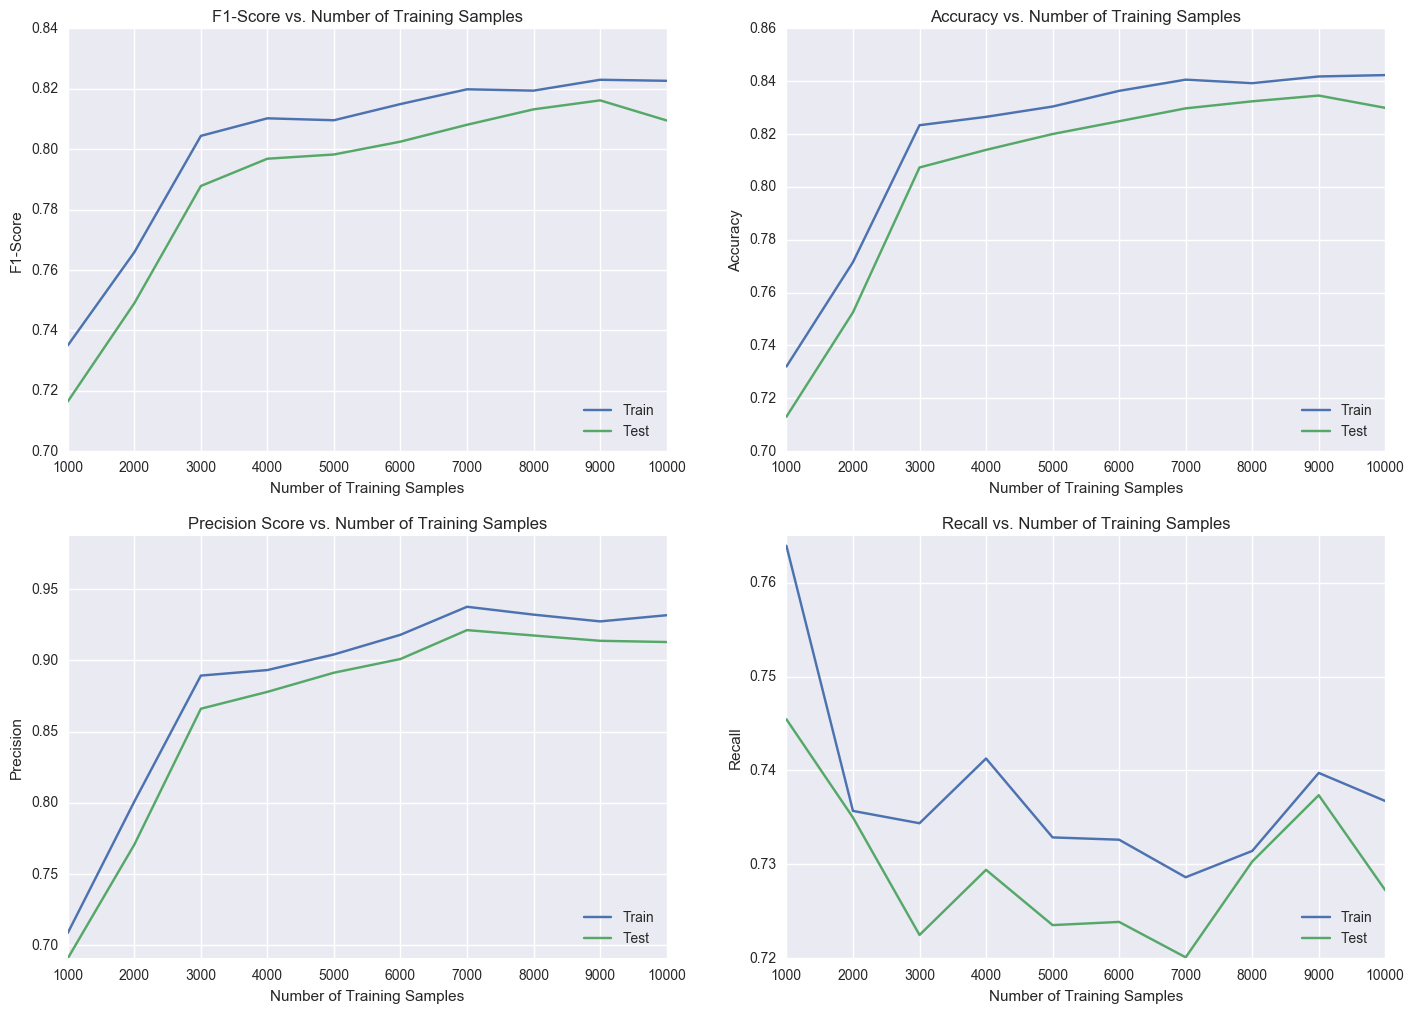

In [43]:
cross_val.train_for_learning_curve()
cross_val.plot_learning_curve()

We can see that SVM's accuracy and precsion metrics performance increases as the number of training samples increase. Recall contains more variance than the other two metrics. We can see there is very little overfitting present. Also SVM's accuracy seems saturates just below 83%. 

### Random Forest Classifier

In [24]:
rfc = RandomForestClassifier(n_estimators=100, 
                             max_leaf_nodes=None, 
                             max_depth=8, 
                             min_samples_split = 6)

In [34]:
n_points = 100000
cross_val = \
cross_validation(rfc, 
                 X_train[:n_points], 
                 Y_train[:n_points], 
                 n_splits=2, 
                 init_chunk_size = 10000, 
                 chunk_spacings = 10000, 
                 average = "binary")

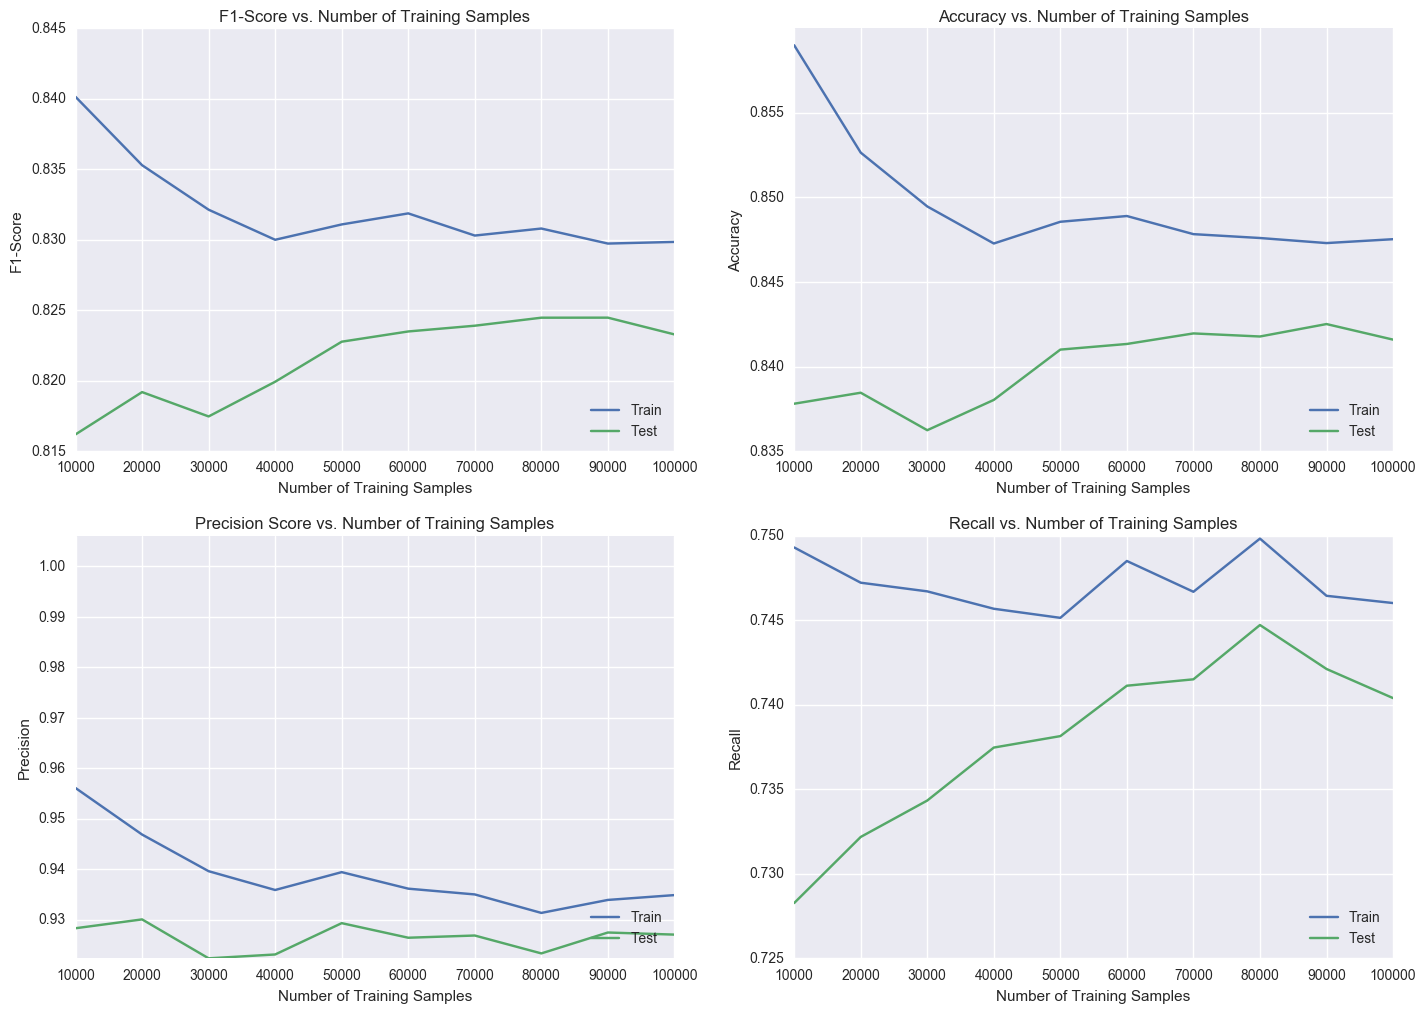

In [35]:
cross_val.train_for_learning_curve()
cross_val.plot_learning_curve()

Random Forest's accuracy peaks a little above 84% and precison fluxuates between 92% and 93%, while recall peaks at 74%. Random Forest suffers from more overfitting than SVM. 

### Gradient Boosting Classifier

In [44]:
gbt = GradientBoostingClassifier(n_estimators=100, 
                                 max_leaf_nodes = 6, 
                                 learning_rate = 0.1, 
                                 max_depth = 2, 
                                 min_samples_split = 2)

In [47]:
n_points = 100000
cross_val = \
cross_validation(gbt, 
                 X_train[:n_points], 
                 Y_train[:n_points], 
                 n_splits=2, 
                 init_chunk_size = 10000, 
                 chunk_spacings = 10000, 
                 average = "binary")

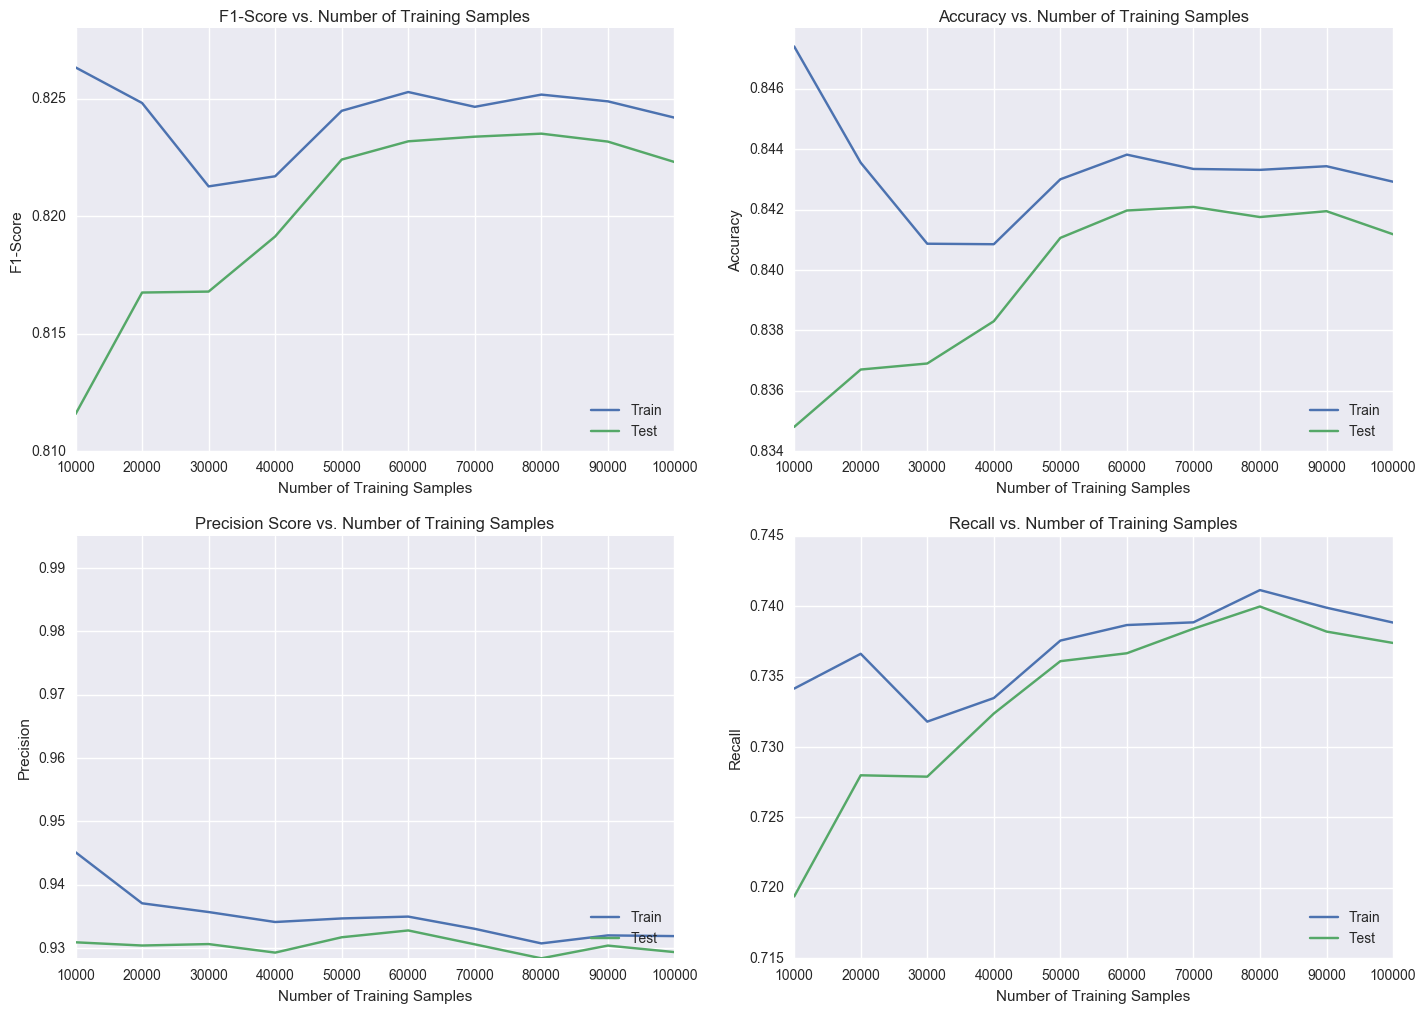

In [48]:
cross_val.train_for_learning_curve()
cross_val.plot_learning_curve()

Gradient Boosting's accuracy peaks around 84% and precison saturates around 93%, with recall peaking at 74%. Gradient Boosting has much less overfitting than Random Forest, which means that it will generalize better than Random Forest. However Gradient Boosting's metrics perform just as well as SVM. Also both models have little overfitting present. So now the question becomes, which of these two models do we use for predictions and why?

We will use SVM for predicting the probability that a user will make a purchase becuase it does a slightly better job at generalizing (less overfitting). Also we'll use Random Forest to determine which features are most important when predicting which user will make a purchase. 

# Results

Now we'll answer the following two questions: 

1. Descibe which activity types you believe are most useful in predicting which user will purchase in the future.
2. Provide a file containing the 1000 user_id's most likely to convert.

### 1. Most Useful Activity Types

In [89]:
rfc = RandomForestClassifier(n_estimators=100, 
                             max_leaf_nodes=None, 
                             max_depth=8, 
                             min_samples_split = 6)

In [91]:
n_points = 9000
rfc.fit(X_train[:n_points], Y_train[:n_points]);

In [92]:
feats = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],axis=0)
indices = np.argsort(feats)[::-1]

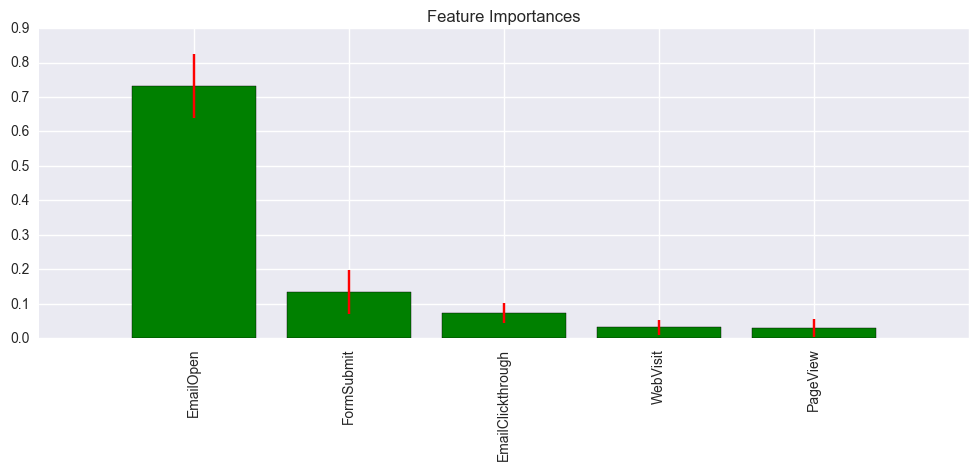

In [107]:
plt.figure(figsize=(12,4))
plt.title("Feature Importances")
plt.bar(list(range(len(feats))), feats[indices], color="g", yerr=std[indices], ecolor='r',align="center")
# shift indicies by 2 to account for removing the first features from X
plt.xticks(list(range(30)), np.array(X_cols)[indices ], rotation=90)
plt.xlim([-1, 5]);
#plt.ylim([0,0.5]);

We can see from the feature importance property from Random Forest that the **EmailOpen** feature is most important when predicting if a user makes a purchase. This indicates that simplying opening an email leads to more purchases. The red error bars represent standard deviation. The error bars are short, indicating high confidence in our results. 

Recall that we dropped **CustomerSupport** from the feature set because this feature does not appear in the test set that we were givein. So we can't train our models with this feature and expect them to predict results for a test set in which this feature is absent. 

### 2. Top 1000 Users Most Likely to Convert

In [119]:
X_cols = ['EmailOpen', 'FormSubmit', 'EmailClickthrough', 'PageView', 'WebVisit']
X = df_test_encode[X_cols].values

In [52]:
n_points = 9000
svc = SVC(kernel = 'rbf', C = 1.0, gamma = 0.01,probability=True)
svc.fit(X_train[:n_points], Y_train[:n_points]);

test_prob = svc.predict_proba(X)
purchase_probs = test_prob.T[1]

In [123]:
# leading indicies belong to users that are most likly to make a purchase
most_likely_to_purchase = purchase_probs.argsort()[::-1]
top_1000 = most_likely_to_purchase[:1000]
# user ids for top 1000 that are most likely to convert
user_ids_most_prob = df_test_encode.iloc[top_1000].index

In [144]:
# save final results to file
converts_data_path = "./top_1000_converts.pkl"
pickle.dump(user_ids_most_prob, open(converts_data_path, 'wb'))

![](http://photos.prnewswire.com/prnvar/20150914/266402LOGO)